In [1]:
import os

os.environ["QUIMB_NUM_THREAD_WORKERS"] = "1"

import matplotlib.pyplot as plt
import sys

import pandas as pd
import pickle

current_dir = os.getcwd()
grandparent_dir = os.path.abspath(os.path.join(current_dir, "../.."))

In [2]:
import numpy as np
import scipy

In [3]:
%config InlineBackend.figure_formats = ['svg']
import seaborn as sns
sns.set_palette('deep')
sns.set_style('whitegrid')
plt.rcParams.update({"font.size": 16})
aw = 2
plt.rcParams["grid.linewidth"] = aw
plt.rcParams["axes.linewidth"] = aw  # Adjust the thickness here
plt.rcParams["figure.figsize"] = 9, 6

In [4]:
fid_results = pickle.load(
    open(
        os.path.join(
            grandparent_dir,
            "data",
            "SU4_opt",
            "SU4_results_fidelity.pickle",
        ),
        "rb",
    )
)

In [6]:
def plot_RB_set_fixed_B(test_set, name, x, save_file=False):

    # x = [2,3,4,8,16]
    ntrials = 25
    y_opt = [np.real(test_set[i]["opt"]) for i in x]
    y_naive = [np.real(test_set[i]["naive"]) for i in x]

    y_opt_flat = np.array(y_opt).flatten()
    y_naive_flat = np.array(y_naive).flatten()

    x_opt = [length for length in x for i in range(ntrials)]

    initial_guess = [0.9, 0.25, 0.9]

    fit_params_opt = scipy.optimize.curve_fit(
        lambda t, A, B, alpha: A * alpha**t + B,
        x_opt,
        y_opt_flat,
        maxfev=10000,
        p0=initial_guess,
    )[0]

    A_fixed = fit_params_opt[0]
    B_fixed = fit_params_opt[1]
    fit_params_naive = scipy.optimize.curve_fit(
        lambda t, alpha: A_fixed * alpha**t + B_fixed,
        x_opt,
        y_naive_flat,
        maxfev=10000,
        p0=[0.9],
    )[0]

    fit_params_naive = [A_fixed, B_fixed, fit_params_naive[0]]
    print(fit_params_naive)

    def RB_func(x_data, A, B, alpha):
        return [A * alpha**m + B for m in x_data]

    x = [2, 3, 4, 8, 16, 32]
    y_opt = [np.real(test_set[i]["opt"]) for i in x]
    y_naive = [np.real(test_set[i]["naive"]) for i in x]

    x_range = np.linspace(2, max(x), 150)
    for xe, ye in zip(x, y_opt):
        plt.scatter([xe] * len(ye), ye, color="blue", s=15)

    for xe, ye in zip(x, y_naive):
        plt.scatter([xe] * len(ye), ye, color="red", s=15)

    try:
        fid_naive = np.mean(
            [fid_results[name]["single_SU4_stats"][i][0] for i in range(100)]
        )
        fid_opt = np.mean(
            [fid_results[name]["single_SU4_stats"][i][1] for i in range(100)]
        )
        print(f"Fid naive: {fid_naive}, fid opt: {fid_opt}")
    except:
        print("No data")

    plt.plot(
        x_range,
        RB_func(x_range, *fit_params_opt),
        color="blue",
        label=f"Optimised, p = {fit_params_opt[2]:.4f}",
    )
    plt.plot(
        x_range,
        RB_func(x_range, *fit_params_naive),
        color="red",
        label=f"Naive, p = {fit_params_naive[2]:.4f}",
    )
    plt.xlabel("Lengths")
    plt.ylabel("Survival Probabilities")
    plt.legend()
    plt.title(name)
    if save_file:
        plt.savefig(name + ".pdf", bbox_inches="tight")
    else:
        plt.show()
    plt.close()

In [7]:
paper_figures = ["cairo_SU4_03_10", "hanoi_SU4_10_10", "mumbai_SU4_03_10"]

[0.7625524169860242, 0.26076383286839, 0.8680372602322618]
Fid naive: 0.8896090749531573, fid opt: 0.9139463640560963


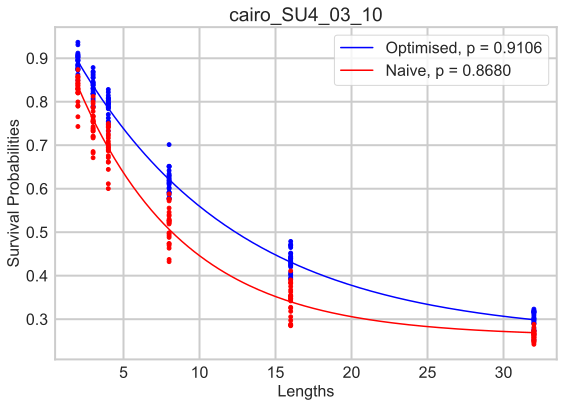

[0.775543532039515, 0.2379302532527833, 0.7935897784601287]
Fid naive: 0.8109508040625333, fid opt: 0.8300591051511107


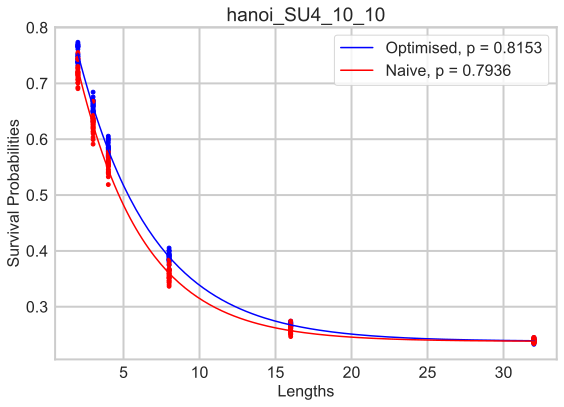

[0.7738433563213343, 0.222248296403643, 0.8234968532681258]
Fid naive: 0.8338196226683866, fid opt: 0.8549880563535099


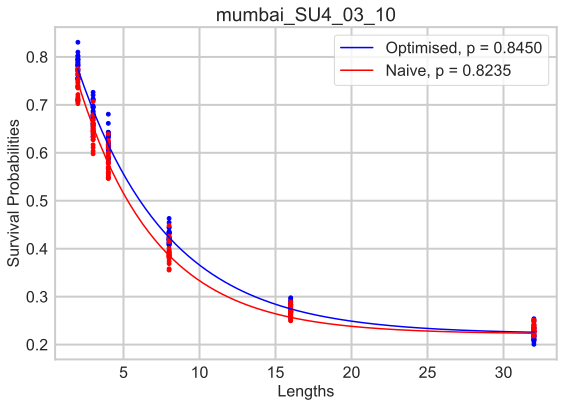

In [8]:
for name in paper_figures:
    tmp_res = pickle.load(
        open(
            os.path.join(
                grandparent_dir,
                "data",
                "SU4_opt",
                "RB_predictions",
                name + "_RB_predictions.pickle",
            ),
            "rb",
        )
    )
    plot_RB_set_fixed_B(tmp_res, name, x=[2, 3, 4, 8, 16, 32], save_file=False)